In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#loading the datasets
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')

#showing the raw data
print("Movies Data:")
display(movies.head())
print("\nRatings Data:")
display(ratings.head())

Matplotlib is building the font cache; this may take a moment.


Movies Data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Data:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#merging the datasets to show user, movie name, and rating
df = pd.merge(ratings, movies, on='movieId')
print("Merged Data (User + Movie Name + Rating):")
display(df[['userId', 'title', 'rating', 'genres']].head())

Merged Data (User + Movie Name + Rating):


,userId,title,rating,genres
0,1,Toy Story (1995),4.0,Adventure|Animation|Children|Comedy|Fantasy
1,1,Grumpier Old Men (1995),4.0,Comedy|Romance
2,1,Heat (1995),4.0,Action|Crime|Thriller
3,1,Seven (a.k.a. Se7en) (1995),5.0,Mystery|Thriller
4,1,"Usual Suspects, The (1995)",5.0,Crime|Mystery|Thriller



Average Rating across all movies: 3.50/5.0


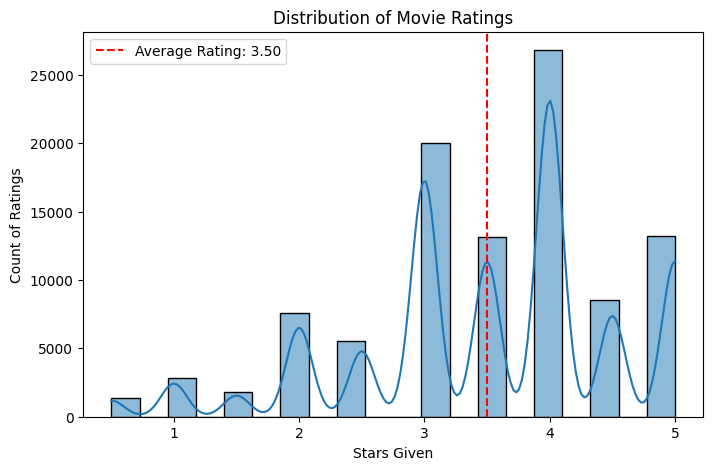

In [6]:
avg_ratings = df['rating'].mean()
print(f"\nAverage Rating across all movies: {avg_ratings:.2f}/5.0")

plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Stars Given')
plt.ylabel('Count of Ratings')
plt.axvline(avg_ratings, color='red', linestyle='--', label=f'Average Rating: {avg_ratings:.2f}')
plt.legend()
plt.show()

In [7]:
# 1. Create the User-Item Matrix
user_item_matrix = df.pivot_table(index='userId', columns='title', values='rating')

# 2. Calculate Sparsity
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
filled_cells = df.shape[0]
sparsity = 1 - (filled_cells / total_cells)

print(f"Total Matrix Cells: {total_cells:,}")
print(f"Actual Ratings: {filled_cells:,}")
print(f"Sparsity: {sparsity:.4%}")
print("Conclusion: The matrix is ~98% empty.")

Total Matrix Cells: 5,928,590
Actual Ratings: 100,836
Sparsity: 98.2992%
Conclusion: The matrix is ~98% empty.
